In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision

In [2]:
#### Model Parameters
dataset=torchvision.datasets.CIFAR100
batch_size = 256
num_epochs = 10
num_workers = 4  # You can use multiple processes to load the data. 0 means that everything is done in the same process
data_dir='CIFAR100_Data'  # Folder that contains the dataset. If it is not present, the dataset will be downloaded into that folder
start_epoch=1

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
kwargs = {'num_workers': num_workers, 'pin_memory': True} if device=='cuda' else {}
kwargs

cuda


{'num_workers': 4, 'pin_memory': True}

In [3]:
transform = torchvision.transforms.Compose([
    # resize
    torchvision.transforms.Resize(32),
    # center-crop
    torchvision.transforms.CenterCrop(32),
    # to-tensor
    torchvision.transforms.ToTensor(),
    # normalize
    torchvision.transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_set=dataset(root=data_dir,train=True,download=True,transform=transform)

test_set=dataset(root=data_dir,train=False,download=True,transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_size=int(0.8 * len(train_set))
val_size=len(train_set)-train_size
train_dataset,validation_dataset=torch.utils.data.random_split(train_set,[train_size, val_size])
                                                                  
train_dataloader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True,**kwargs)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset,batch_size=batch_size,shuffle=True,**kwargs)
test_dataloader=torch.utils.data.DataLoader(test_set,batch_size=batch_size,shuffle=False,**kwargs)
print(train_size)
print(val_size)
print(len(test_set))

40000
10000
10000


In [5]:
data_iterator_train=iter(train_dataloader)
images,labels=data_iterator_train.next()
print(images.shape)
print(images.device)

torch.Size([256, 3, 32, 32])
cpu


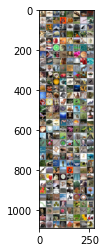

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def imshow(img):
     img=img/2+0.5
     npimg=img.numpy()
     plt.imshow(np.transpose(npimg, (1, 2, 0)))
     plt.show()

imshow(torchvision.utils.make_grid(images))

In [7]:
import torch.optim as optim
from torch.autograd import Variable
import time
import numpy as np
from torch.optim import lr_scheduler

use_cuda = torch.cuda.is_available()

def train_one_epoch(epoch,model, trainloader, optimizer, criterion):
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        accuracy = get_accuracy(outputs, targets)
        train_accuracy += accuracy[0].item()
    avg_train_loss = train_loss/(batch_idx+1)
    avg_train_acc = train_accuracy/(batch_idx+1)
    
    print ('\n=> Training Epoch [%3d/%3d] \tTraining Loss: %.4f%% Training Accuracy: %.3f%%'
                %(epoch, num_epochs,avg_train_loss,avg_train_acc)) 
    return avg_train_loss, avg_train_acc, model

def validate(epoch,net, valoader, criterion):
    val_loss = 0
    val_accuracy = 0
    net.eval()
    y_pred=[]
    
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(valoader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            accuracy = get_accuracy(outputs, targets)
            val_accuracy += accuracy[0].item()
        avg_loss = val_loss/(batch_idx+1)
        avg_acc = val_accuracy/(batch_idx+1)
    
    print(" | Validation Epoch #%d\t\tValidation Loss: %.4f%% Validation Accuracy: %.2f%%" % (epoch, avg_loss, avg_acc))
    return avg_loss, avg_acc

def get_accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the 
    k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

def start_train_valid(net,trainloader, validloader, criterion):
    elapsed_time = 0
    lr=0.1
    train_loss,train_accuracy,validation_loss,validation_accuracy=[],[],[],[]
    for epoch in range(start_epoch,start_epoch+num_epochs):
        start_time = time.time()
        optimizer=optim.SGD(net.parameters(),lr, momentum=0.9)
        trainloss,trainaccuracy,net = train_one_epoch(epoch,net,trainloader,optimizer,criterion)
        validationloss,validationaccuracy = validate(epoch,net,validloader,criterion)
        train_loss.append(trainloss)
        validation_loss.append(validationloss)
        train_accuracy.append(trainaccuracy)
        validation_accuracy.append(validationaccuracy)
        epoch_time = time.time() - start_time
        elapsed_time += epoch_time
        print(' | Elapsed time : %d:%02d:%02d' % (get_hms(elapsed_time)))

    return train_loss, train_accuracy,validation_loss, validation_accuracy

def get_hms(seconds):
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return h, m, s

In [8]:
resnet18=torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
### Plot accuracy and loss

from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, FactorRange
from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.transform import dodge

output_notebook()

def plot_history(source,title,epoch_num):
    # TODO: Plot training and validation curves for avg. loss and accuracy
    
    p = figure(x_range=epoch_num, plot_height=400, title='Train '+title+' vs Test '+title,
           toolbar_location=None, tools="")

    #p.vbar(x='x', top='counts', width=0.9, source=source, fill_color=factor_cmap('x', palette=palette, factors=years, start=1, end=2))
    
    p.vbar(x=dodge('epoch_num', -0.25, range=p.x_range), top='Train', width=0.2, source=source,
       color="#B4EEB4", legend_label="Train")

    p.vbar(x=dodge('epoch_num',  0.0,  range=p.x_range), top='Validation', width=0.2, source=source,
       color="#FDD6E5", legend_label="Validation")

    p.x_range.range_padding = 0.1
    p.xgrid.grid_line_color = None
    p.legend.location = "top_left"
    p.legend.orientation = "horizontal"
    p.xaxis.axis_label = "Epoch Number"
    p.yaxis.axis_label = title

    show(p)


Loading BokehJS ...

In [10]:
### Confusion Matrix and Classification Report

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def confusion_matrix_classification_report(network, test_iter, num_classes=100, device='cuda'):
    network.eval()
    mat = torch.zeros(size=(num_classes, num_classes), dtype=torch.get_default_dtype(),
                        device='cpu')
    y_true=[]
    y_pred=[]
    for data,label in test_iter:
        data = data.to(device)
        result = network(data)
        result = torch.argmax(result, dim=-1).data.cpu()
        
        idx = torch.stack([label, result], dim=1)
        #print(idx)
        idx, count = torch.unique(idx, dim=0, return_counts=True)
        mat[idx[:,0], idx[:,1]] += count
        
        y_true.append(label.cpu().numpy())
        y_pred.append(result.numpy())
    
    
    flat_pred = []
    flat_true = []
    for i in range(len(y_pred)):
        for j in range(len(y_pred[i])):
            flat_pred.append(y_pred[i][j])
            flat_true.append(y_true[i][j])
            
    #print("number of testing samples results:", len(flat_pred))     
       
    class_report=classification_report(flat_true,flat_pred)
    mat /= torch.sum(mat, dim=1, keepdims=True)
    
    return mat,class_report

***************================= Train Resnet by All layers ===================***************

=> Training Epoch [  1/ 10] 	Training Loss: 4.8381% Training Accuracy: 2.948%
 | Validation Epoch #1		Validation Loss: 26.1114% Validation Accuracy: 2.64%
 | Elapsed time : 0:00:37

=> Training Epoch [  2/ 10] 	Training Loss: 3.9678% Training Accuracy: 7.760%
 | Validation Epoch #2		Validation Loss: 3.7023% Validation Accuracy: 10.96%
 | Elapsed time : 0:01:16

=> Training Epoch [  3/ 10] 	Training Loss: 3.4640% Training Accuracy: 15.764%
 | Validation Epoch #3		Validation Loss: 3.3565% Validation Accuracy: 18.15%
 | Elapsed time : 0:01:54

=> Training Epoch [  4/ 10] 	Training Loss: 3.0140% Training Accuracy: 24.104%
 | Validation Epoch #4		Validation Loss: 2.9785% Validation Accuracy: 25.86%
 | Elapsed time : 0:02:33

=> Training Epoch [  5/ 10] 	Training Loss: 2.6886% Training Accuracy: 30.531%
 | Validation Epoch #5		Validation Loss: 2.7744% Validation Accuracy: 30.04%
 | Elapsed time : 


Confusion Matrix : 
 tensor([[0.2900, 0.0000, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.3000, 0.0300,  ..., 0.0000, 0.0000, 0.0300],
        [0.0000, 0.0000, 0.3300,  ..., 0.0100, 0.0400, 0.0100],
        ...,
        [0.0000, 0.0000, 0.0100,  ..., 0.1800, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1600,  ..., 0.0200, 0.1000, 0.0200],
        [0.0100, 0.0000, 0.0100,  ..., 0.0100, 0.0000, 0.2500]])

Classification Report : 
               precision    recall  f1-score   support

           0       0.64      0.29      0.40       100
           1       0.38      0.30      0.33       100
           2       0.12      0.33      0.18       100
           3       0.00      0.00      0.00       100
           4       0.20      0.02      0.04       100
           5       0.15      0.19      0.17       100
           6       0.31      0.41      0.35       100
           7       0.38      0.33      0.35       100
           8       0.11      0.74      0.19       100
           9

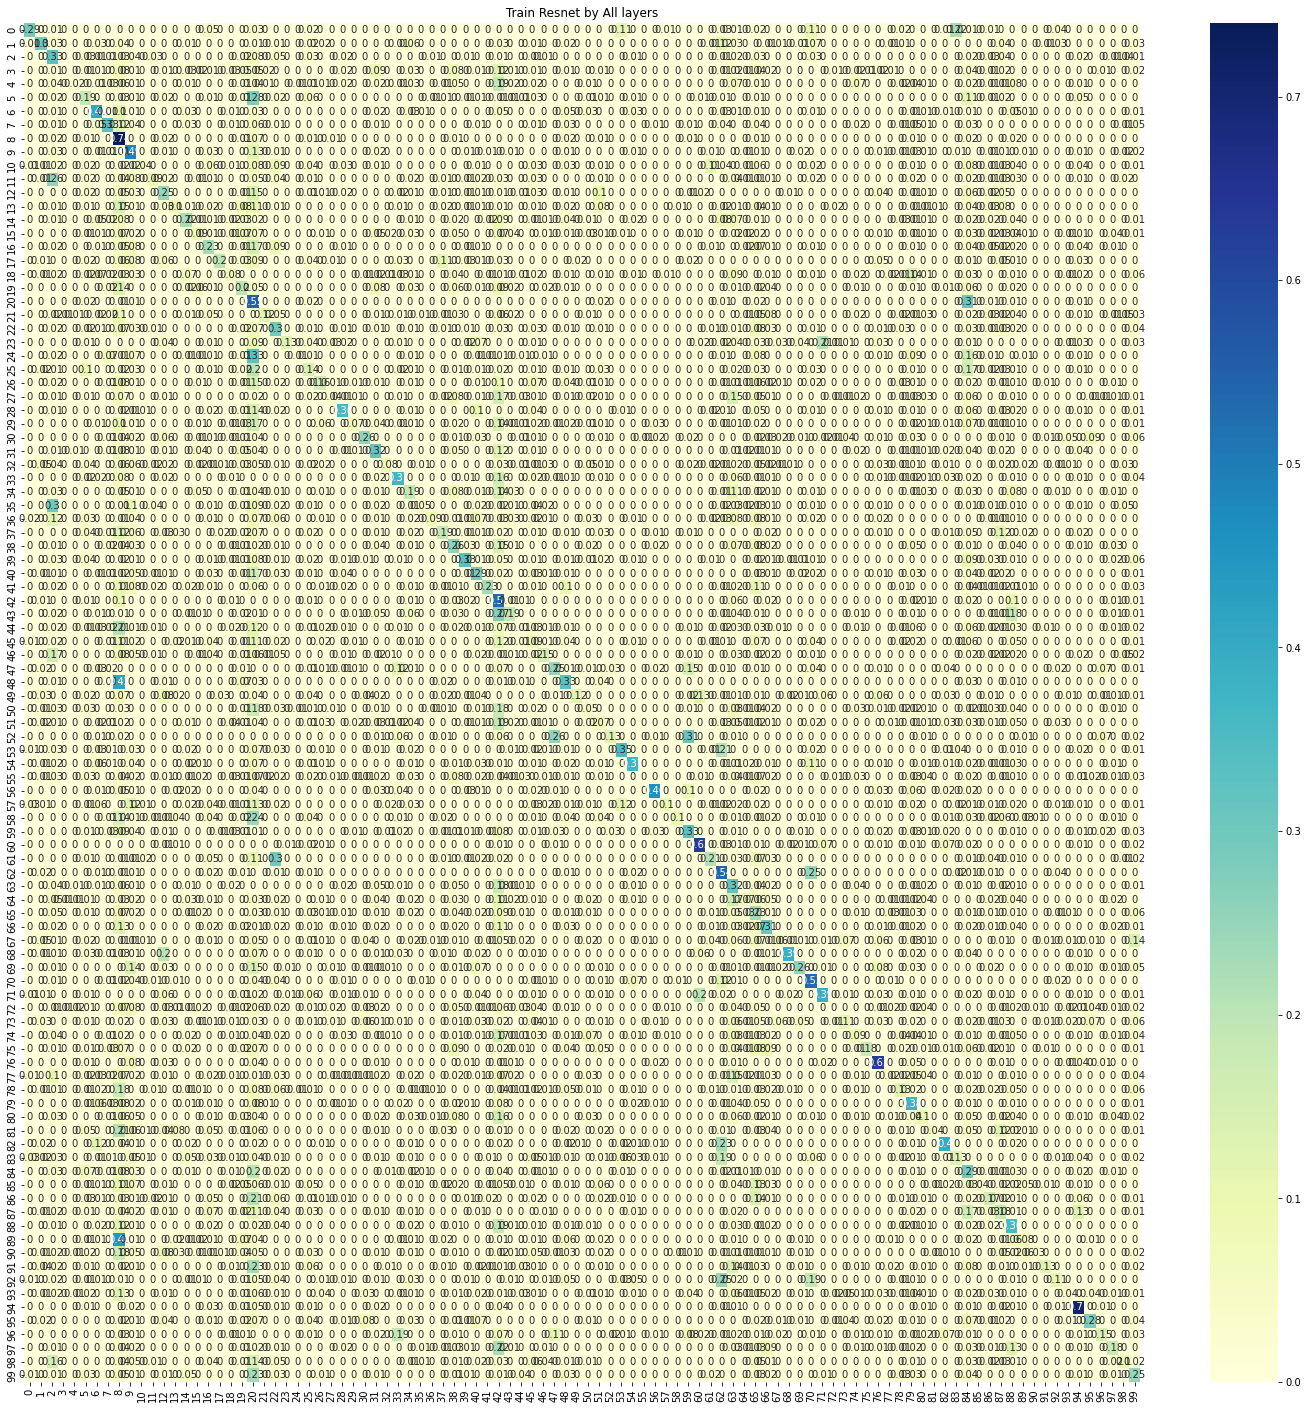


***************=================================================================***************


***************================= Train Resnet by freezing All layers except Layer : 1 ===================***************

=> Training Epoch [  1/ 10] 	Training Loss: 24.1925% Training Accuracy: 11.895%
 | Validation Epoch #1		Validation Loss: 28.4622% Validation Accuracy: 13.15%
 | Elapsed time : 0:00:22

=> Training Epoch [  2/ 10] 	Training Loss: 26.3396% Training Accuracy: 15.078%
 | Validation Epoch #2		Validation Loss: 28.5056% Validation Accuracy: 14.75%
 | Elapsed time : 0:00:46

=> Training Epoch [  3/ 10] 	Training Loss: 26.1546% Training Accuracy: 15.563%
 | Validation Epoch #3		Validation Loss: 29.6301% Validation Accuracy: 16.04%
 | Elapsed time : 0:01:09

=> Training Epoch [  4/ 10] 	Training Loss: 26.3216% Training Accuracy: 16.675%
 | Validation Epoch #4		Validation Loss: 31.1082% Validation Accuracy: 15.34%
 | Elapsed time : 0:01:32

=> Training Epoch [  5/ 10] 	Training L


Confusion Matrix : 
 tensor([[0.6700, 0.0100, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2400, 0.0300,  ..., 0.0000, 0.0000, 0.0000],
        [0.0200, 0.0400, 0.0700,  ..., 0.0100, 0.0100, 0.0100],
        ...,
        [0.0000, 0.0300, 0.0000,  ..., 0.1300, 0.0200, 0.0000],
        [0.0000, 0.0100, 0.0600,  ..., 0.0000, 0.0100, 0.0000],
        [0.0100, 0.0200, 0.0000,  ..., 0.0000, 0.0000, 0.3100]])

Classification Report : 
               precision    recall  f1-score   support

           0       0.72      0.67      0.69       100
           1       0.14      0.24      0.17       100
           2       0.11      0.07      0.08       100
           3       0.06      0.09      0.07       100
           4       0.03      0.03      0.03       100
           5       0.12      0.09      0.10       100
           6       0.09      0.18      0.12       100
           7       0.23      0.26      0.25       100
           8       0.14      0.15      0.15       100
           9

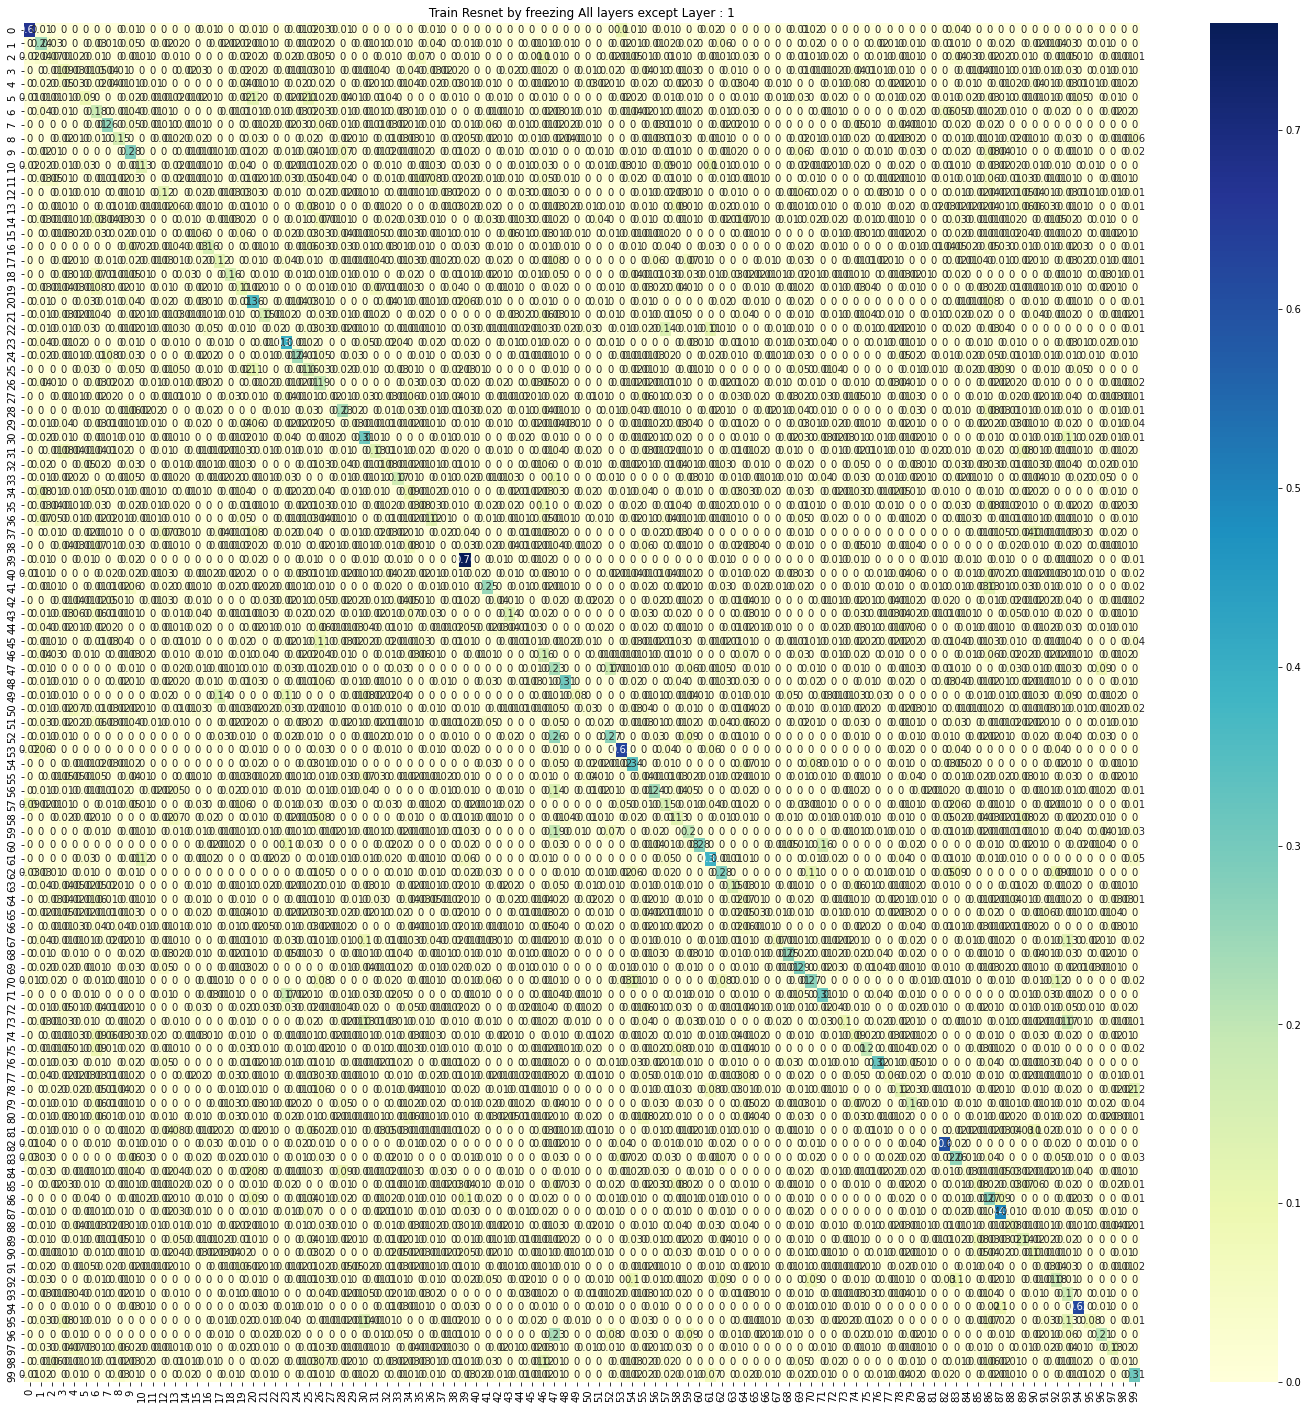


***************=================================================================***************


***************================= Train Resnet by freezing All layers except Layer : 2 ===================***************

=> Training Epoch [  1/ 10] 	Training Loss: 24.6535% Training Accuracy: 11.913%
 | Validation Epoch #1		Validation Loss: 29.2039% Validation Accuracy: 13.30%
 | Elapsed time : 0:00:23

=> Training Epoch [  2/ 10] 	Training Loss: 26.2579% Training Accuracy: 15.155%
 | Validation Epoch #2		Validation Loss: 29.4709% Validation Accuracy: 14.38%
 | Elapsed time : 0:00:45

=> Training Epoch [  3/ 10] 	Training Loss: 26.1884% Training Accuracy: 15.866%
 | Validation Epoch #3		Validation Loss: 28.7980% Validation Accuracy: 15.52%
 | Elapsed time : 0:01:08

=> Training Epoch [  4/ 10] 	Training Loss: 25.8310% Training Accuracy: 16.934%
 | Validation Epoch #4		Validation Loss: 29.8791% Validation Accuracy: 14.86%
 | Elapsed time : 0:01:30

=> Training Epoch [  5/ 10] 	Training L


Confusion Matrix : 
 tensor([[0.7100, 0.0100, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.1700, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0900,  ..., 0.0000, 0.0300, 0.0000],
        ...,
        [0.0000, 0.0100, 0.0000,  ..., 0.1400, 0.0400, 0.0000],
        [0.0000, 0.0000, 0.0300,  ..., 0.0000, 0.0600, 0.0000],
        [0.0100, 0.0100, 0.0000,  ..., 0.0000, 0.0100, 0.0700]])

Classification Report : 
               precision    recall  f1-score   support

           0       0.53      0.71      0.61       100
           1       0.22      0.17      0.19       100
           2       0.19      0.09      0.12       100
           3       0.13      0.02      0.03       100
           4       0.06      0.01      0.02       100
           5       0.19      0.04      0.07       100
           6       0.10      0.18      0.13       100
           7       0.20      0.11      0.14       100
           8       0.07      0.19      0.11       100
           9

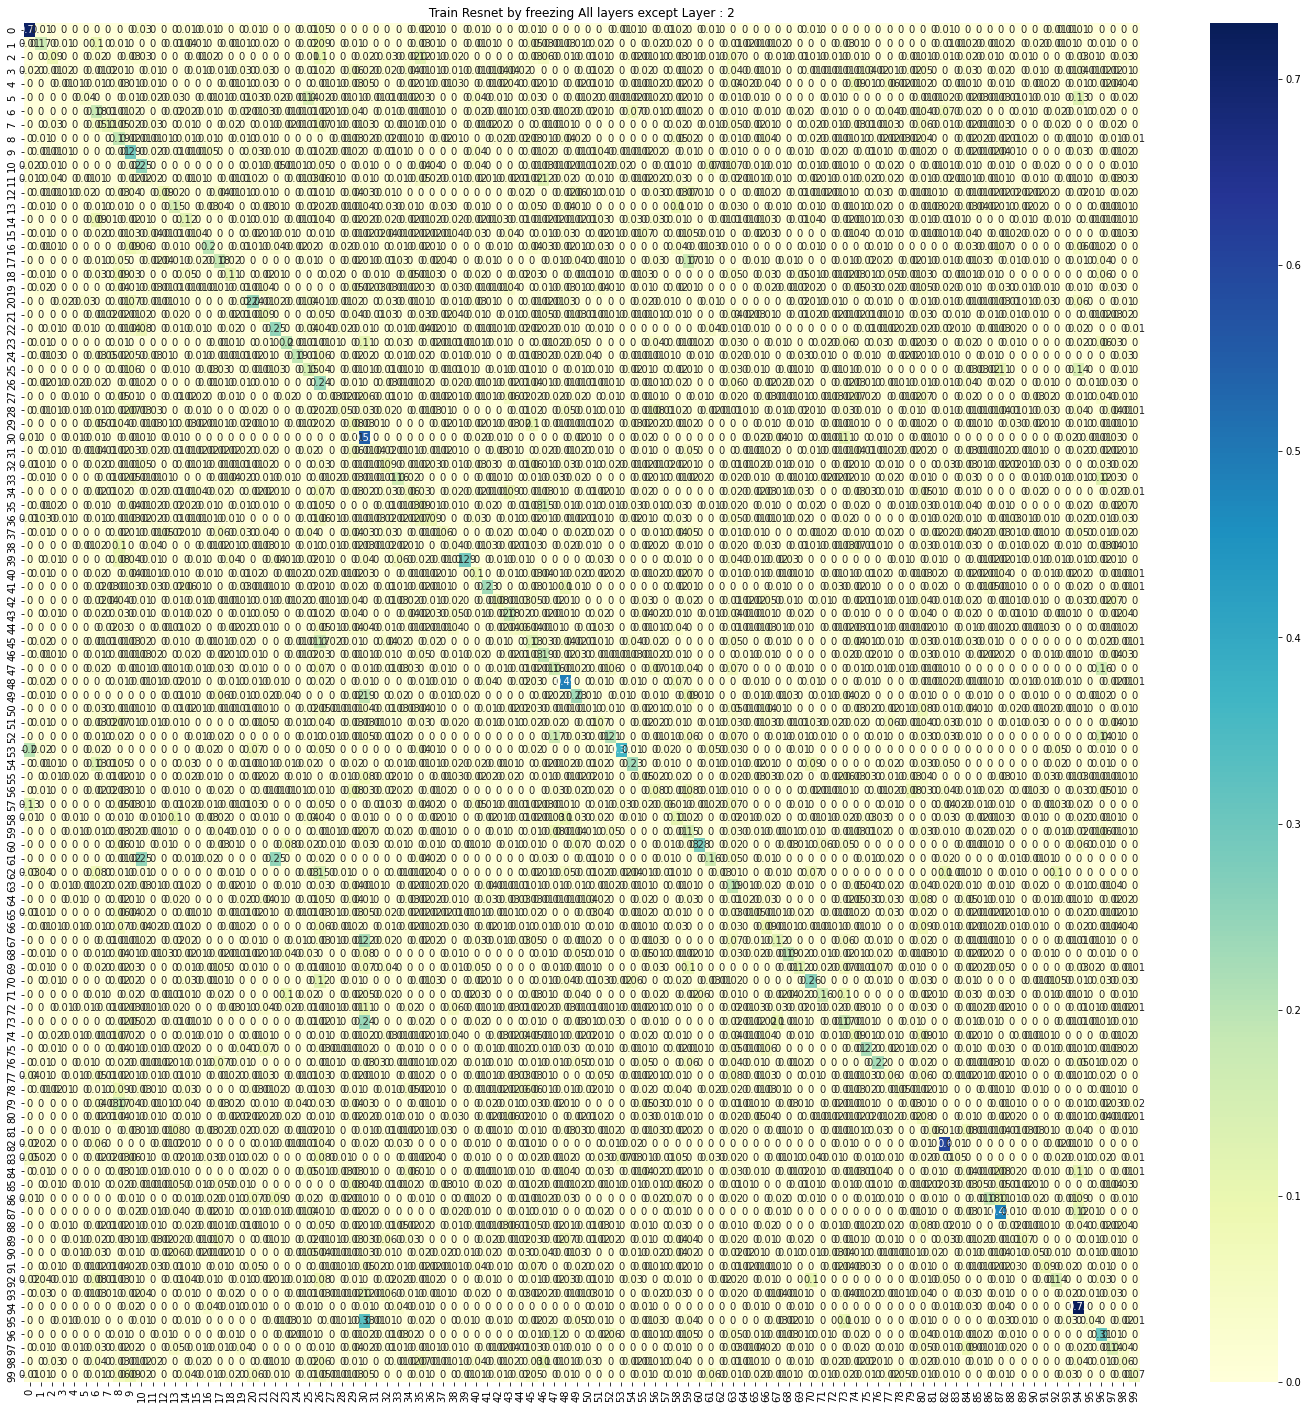


***************=================================================================***************


***************================= Train Resnet by freezing All layers except Layer : 3 ===================***************

=> Training Epoch [  1/ 10] 	Training Loss: 24.7298% Training Accuracy: 11.980%
 | Validation Epoch #1		Validation Loss: 27.0506% Validation Accuracy: 14.85%
 | Elapsed time : 0:00:22

=> Training Epoch [  2/ 10] 	Training Loss: 26.3978% Training Accuracy: 14.993%
 | Validation Epoch #2		Validation Loss: 30.7062% Validation Accuracy: 14.42%
 | Elapsed time : 0:00:45

=> Training Epoch [  3/ 10] 	Training Loss: 26.4328% Training Accuracy: 16.088%
 | Validation Epoch #3		Validation Loss: 29.6265% Validation Accuracy: 14.50%
 | Elapsed time : 0:01:09

=> Training Epoch [  4/ 10] 	Training Loss: 26.1429% Training Accuracy: 16.789%
 | Validation Epoch #4		Validation Loss: 29.6214% Validation Accuracy: 15.77%
 | Elapsed time : 0:01:32

=> Training Epoch [  5/ 10] 	Training L


Confusion Matrix : 
 tensor([[0.5900, 0.0100, 0.0000,  ..., 0.0000, 0.0100, 0.0000],
        [0.0100, 0.0900, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 0.0000, 0.0200,  ..., 0.0000, 0.0200, 0.0200],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.1200, 0.0000, 0.0000],
        [0.0000, 0.0100, 0.0000,  ..., 0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2800]])

Classification Report : 
               precision    recall  f1-score   support

           0       0.87      0.59      0.70       100
           1       0.11      0.09      0.10       100
           2       0.11      0.02      0.03       100
           3       0.04      0.08      0.06       100
           4       0.02      0.07      0.03       100
           5       0.05      0.04      0.04       100
           6       0.12      0.17      0.14       100
           7       0.21      0.16      0.18       100
           8       0.19      0.21      0.20       100
           9

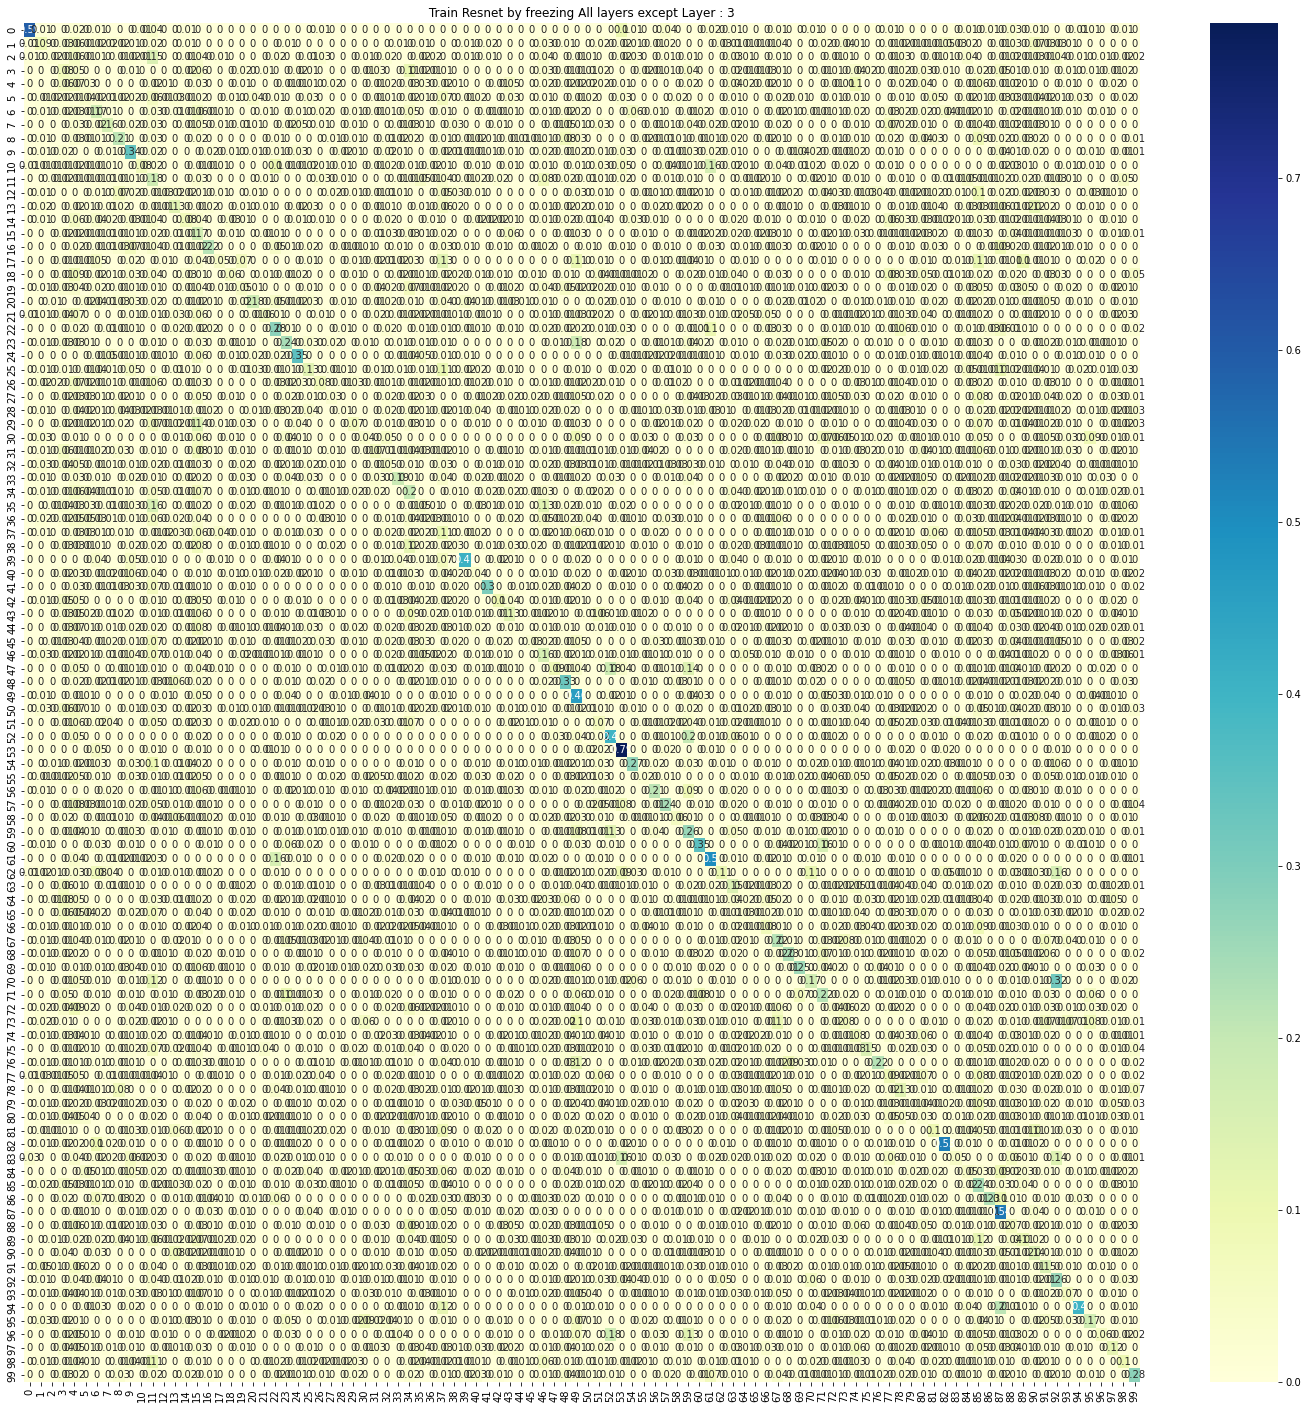


***************=================================================================***************


***************================= Train Resnet by freezing All layers except Layer : 4 ===================***************

=> Training Epoch [  1/ 10] 	Training Loss: 25.0883% Training Accuracy: 11.796%
 | Validation Epoch #1		Validation Loss: 28.3594% Validation Accuracy: 14.76%
 | Elapsed time : 0:00:21

=> Training Epoch [  2/ 10] 	Training Loss: 26.6855% Training Accuracy: 14.943%
 | Validation Epoch #2		Validation Loss: 28.1927% Validation Accuracy: 14.80%
 | Elapsed time : 0:00:44

=> Training Epoch [  3/ 10] 	Training Loss: 26.2319% Training Accuracy: 16.036%
 | Validation Epoch #3		Validation Loss: 30.6342% Validation Accuracy: 14.68%
 | Elapsed time : 0:01:05

=> Training Epoch [  4/ 10] 	Training Loss: 25.9204% Training Accuracy: 16.533%
 | Validation Epoch #4		Validation Loss: 30.5431% Validation Accuracy: 15.46%
 | Elapsed time : 0:01:26

=> Training Epoch [  5/ 10] 	Training L


Confusion Matrix : 
 tensor([[0.5300, 0.0000, 0.0100,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0400, 0.0300,  ..., 0.0000, 0.0200, 0.0000],
        [0.0400, 0.0000, 0.2000,  ..., 0.0000, 0.0900, 0.0100],
        ...,
        [0.0000, 0.0000, 0.0400,  ..., 0.0700, 0.0200, 0.0000],
        [0.0000, 0.0000, 0.0500,  ..., 0.0000, 0.1600, 0.0000],
        [0.0100, 0.0000, 0.0000,  ..., 0.0000, 0.0200, 0.3300]])

Classification Report : 
               precision    recall  f1-score   support

           0       0.60      0.53      0.56       100
           1       0.11      0.04      0.06       100
           2       0.07      0.20      0.11       100
           3       0.10      0.03      0.05       100
           4       0.04      0.03      0.04       100
           5       0.08      0.08      0.08       100
           6       0.07      0.21      0.11       100
           7       0.43      0.18      0.25       100
           8       0.26      0.23      0.24       100
           9

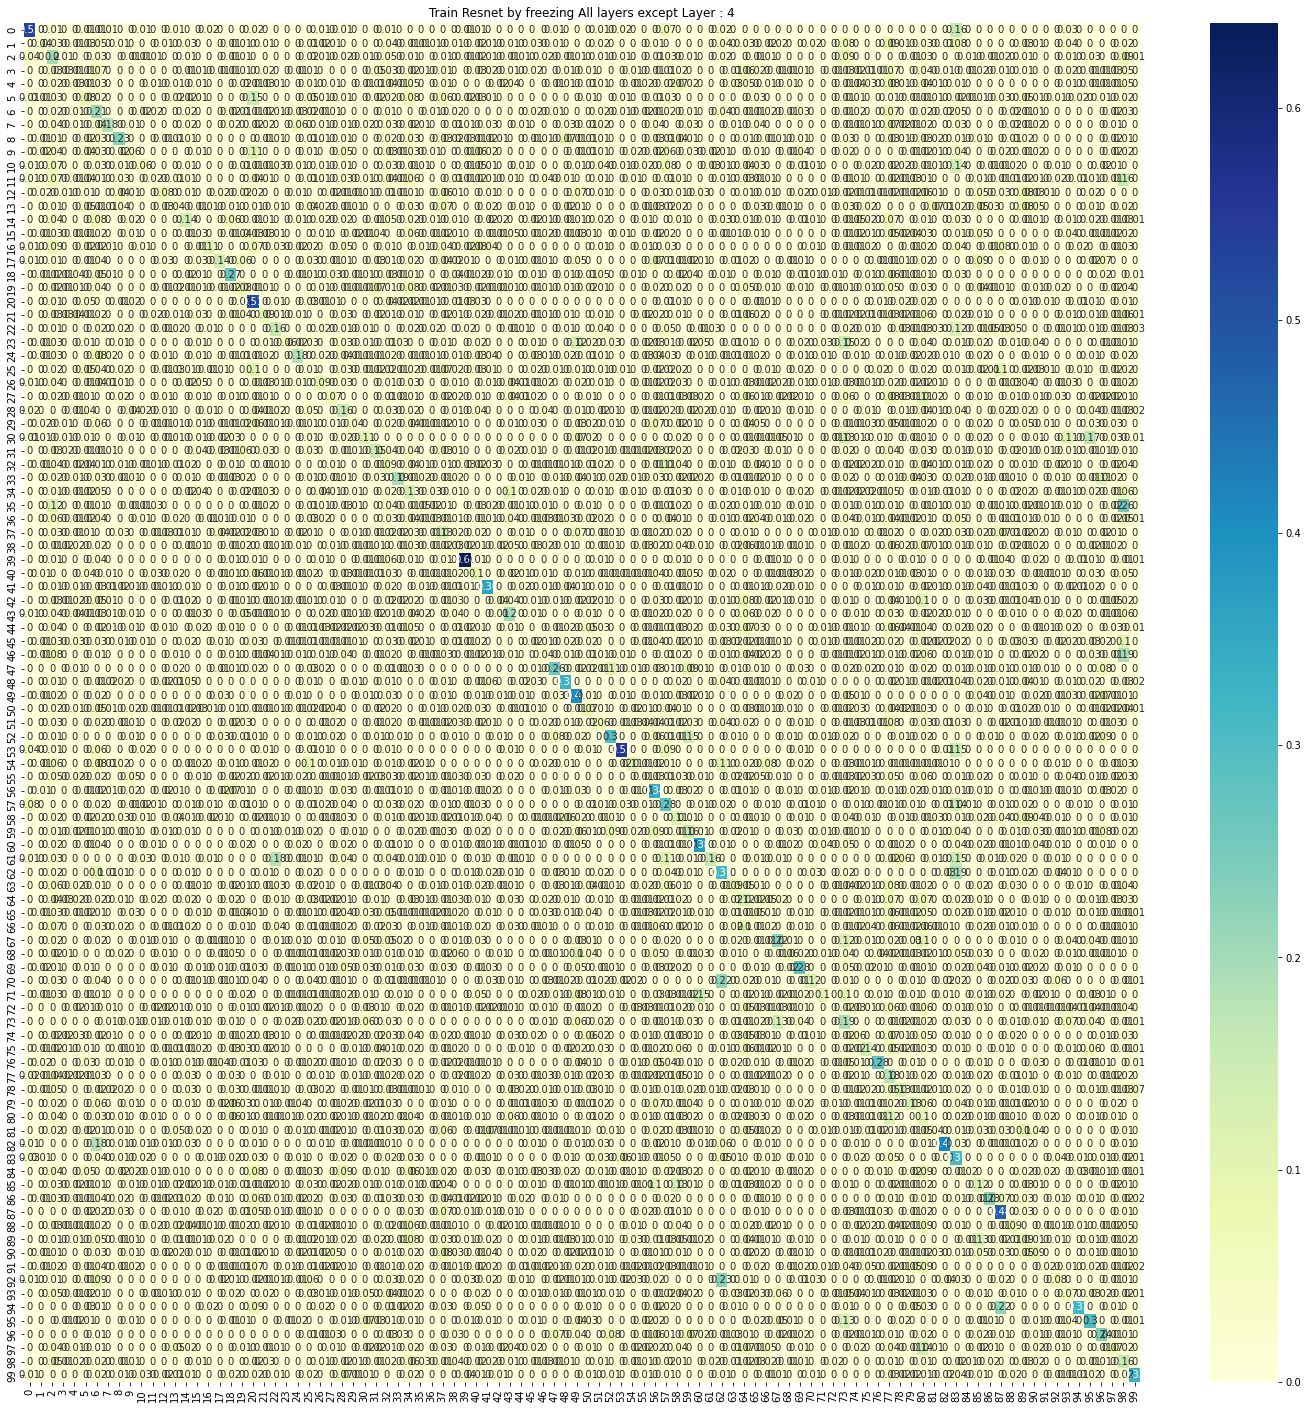


***************=================================================================***************




In [12]:
### Method to freeze layers as required
### i=0 Train using all layers
### i=1 freeze all layers except the first one
### i=2 freeze all layers except the second one
### i=3 freeze all layers except the third one
### i=4 freeze all layers except the fourth one


def freeze_resnet(i):
    resnet18=torchvision.models.resnet18(pretrained=True)
    if(i!=0):  #### Freeze all layers except layer i
        for name, child in resnet18.named_children():
            if(name!='layer'+'i'):
                for name2, params in child.named_parameters():
                    params.requires_grad = False
 
    resnet18=nn.Sequential(resnet18,nn.Linear(1000, 100))
    resnet18=resnet18.to(device)
    return resnet18

for i in range(5):
    if(i!=0):
        title=" Train Resnet by freezing All layers except Layer : "+str(i)+" "
    else:
        title=" Train Resnet by All layers "
    print("***************================="+title+"===================***************")
    resnet18=freeze_resnet(i)
    criterion = nn.CrossEntropyLoss()
    train_loss,train_accuracy,validation_loss,validation_accuracy=start_train_valid(resnet18,train_dataloader,validation_dataloader,criterion)
    
    epoch_num = []
    for i in range(num_epochs):
        epoch_num.append(str(i+1))
    
    source_loss = ColumnDataSource(data={'epoch_num': epoch_num,'Train': train_loss,'Validation': validation_loss })
    plot_history(source_loss,'Loss',epoch_num)

    source_acc = ColumnDataSource(data={'epoch_num': epoch_num,'Train': train_accuracy,'Validation': validation_accuracy })
    plot_history(source_acc,'Accuracy',epoch_num)
    
    result_matrix,class_report = confusion_matrix_classification_report(resnet18,test_dataloader,device=device)
    print("\nConfusion Matrix : \n",result_matrix)
    print("\nClassification Report : \n",class_report)

    plot_matrix = pd.DataFrame(result_matrix.numpy())
    plt.figure(figsize = (25,25))
    sn.heatmap(plot_matrix, annot=True, cmap="YlGnBu")
    plt.title(title)
    plt.show()
    
    print("\n***************=================================================================***************\n\n")